# Session 3 - Random Forest Model Tuning

This is an introductory notebook to familiarize yourself with optimization techniques for Machine Learning (ML). For this work, we will use data from the Moderate Resolution Imaging Spectroradiometer (MODIS) instrument  and a Random Forest algorithm to perform water classification. This same workflow can be adapted to other applications and by using other algorithms.

Author: Caleb S. Spradlin, Jordan A. Caraballo-Vega  
Release Date: 2023.04.08  
Last Modified: 2023.04.08  

## 1. Import Libraries

In this section we import the Python libraries to use during the development of this notebook. The default Python kernel from Google Colab does not include all fo the packages we need, thus we proceed to install them via pip.

In [52]:
!wget https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py

--2023-04-12 06:54:04--  https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6189 (6.0K) [text/plain]
Saving to: ‘folium_helper.py.1’

folium_helper.py.1  100%[===================>]   6.04K  --.-KB/s    in 0s      

2023-04-12 06:54:04 (44.5 MB/s) - ‘folium_helper.py.1’ saved [6189/6189]



In [53]:
!pip install datasets optuna rasterio pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import os
import sys
import csv
import datetime
import glob
import joblib
import numpy as np
import datasets
import pandas as pd
from pathlib import Path   
import optuna

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance
from huggingface_hub import snapshot_download

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal
import folium
from folium import plugins
import folium_helper

from pprint import pprint

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables

In this section we define general variables to work with through this notebook. A description of each variable is listed below as a comment next to the variable definition.

In [55]:
FIGURE_OUTPUT_DIR = 'output'
RASTER_OUTPUT_DIR = 'output'
MODEL_OUTPUT_DIR = 'models'

# url of the dataset we will be using, this is a link to the Hugging Face repository
# of this tutorial
DATASET_URL = 'nasa-cisto-data-science-group/modis-lake-powell-toy-dataset'

TILE = 'global'
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
colsToDrop = []
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']



Here we create an output directory to store any artifacts out of our models and visualizations.

In [56]:
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURE_OUTPUT_DIR, exist_ok=True)

## 3. Data Loading

In this section we will go ahead and load our data to analyze. We have extracted a tabular dataset from MODIS GeoTIFF files for the purpose of performing EDA. Here we will:

- Read in data to a Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [57]:
%%time
train_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='train'))
test_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='test'))

CPU times: user 337 ms, sys: 15.9 ms, total: 353 ms
Wall time: 1.36 s


Here we perform the split of the dataframe into train and test:

In [58]:
X_train, y_train = train_dataset.drop(['water'], axis=1), train_dataset['water']
X_test, y_test = test_dataset.drop(['water'], axis=1), test_dataset['water']
X_train.shape, X_test.shape

((800, 10), (200, 10))

Our column features are listed below:

In [59]:
_ = [print(column) for column in X_train.columns]


sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


Here we can then observe some statistics from the dataset, including some outliers from the NDVI, NDWI1 and NDWI2.

In [60]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,800.0,1209.75875,1287.886517,8.0,238.25,886.5,1893.25,9222.0
sur_refl_b02_1,800.0,1577.25375,1554.828794,1.0,168.00,1394.0,2667.75,8837.0
sur_refl_b03_1,800.0,743.00000,1004.334475,-100.0,286.00,540.0,857.00,8909.0
sur_refl_b04_1,800.0,1028.39500,1065.582946,6.0,413.00,809.5,1313.25,9162.0
sur_refl_b05_1,800.0,1969.37125,1467.613243,-92.0,553.50,1818.5,3210.75,6382.0
sur_refl_b06_1,800.0,1932.65875,1541.910775,51.0,511.25,1498.5,3254.25,6610.0
sur_refl_b07_1,800.0,1587.69625,1395.266352,0.0,316.75,1174.0,2672.00,6128.0
ndvi,800.0,87.13125,2518.736818,-9493.0,-1533.00,733.5,1729.50,8587.0
ndwi1,800.0,-2336.03750,3404.038705,-9862.0,-4577.50,-1582.0,-766.50,8823.0
ndwi2,800.0,-914.29125,3863.695634,-9692.0,-2846.25,-703.5,869.00,10000.0


In [61]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [62]:
output_interesting_idx(X_train, 'ndvi', 10000)


,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2


In [63]:
output_interesting_idx(X_train, 'ndwi1', 10000)


,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2


In [64]:
output_interesting_idx(X_train, 'ndwi2', 10000)


,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2


## 4. Model definition and training

Set TREES_ONLY to True if you only want to tune number of estimators, else max_depth, max_samples_split, min_samples_leaf will be tuned as well. All of these parameters play an important role in the tuning of models.

In the case of a Random Forest, the number of estimators is the number of trees used for splitting decisions. In a neural network depth can be represented as the number of layer per block, and so forth.

The core element of importance is to understand the basics behind the nature of hyperparameters, and how to interpret them across other algorithms.

In [65]:
TREES_ONLY = True

Once we understand which parameters we want to test, we can proceed to define an objective function that can iterate over multiple hyperparameters and find the best possible optimization.

We can do this manually as well based on expert knowledge about the algorithm. For example, increasing the number of estimators if overfitting is present in the model. However, using an objective function as the base will allow us to rapidly tune our model close to its final performance.

In the next cell we define several number of trees, depths to test, and other parameters related to the architecture of the Random Forest. We also define our metrics which in this case will be precision, the F1 score (harmonic mean of precision and recall), and the rate of false positives.

In [66]:
def objective(trial):
    list_trees = [75, 100, 125, 150, 175, 200, 250, 300, 400, 500]
    max_depth = [80, 90, 100, 110]
    min_samples_leaf = [1, 2, 3, 4, 5]
    min_samples_split = [2, 4, 8, 10]
    bootstrap = [True, False]
    
    if TREES_ONLY:
        param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
                   'criterion':'gini', 
                   'max_depth':None, 
                   'min_samples_split':2, 
                   'min_samples_leaf':1, 
                   'min_weight_fraction_leaf':0.0, 
                   'max_features':'auto', 
                   'max_leaf_nodes':None, 
                   'min_impurity_decrease':0.0, 
                   'bootstrap':True, 
                   'oob_score':False, 
                   'n_jobs':-1, 
                   'random_state':42, 
                   'verbose':0, 
                   'warm_start':True, 
                   'class_weight':None, 
                   'ccp_alpha':0.0, 
                   'max_samples':None
                      }
    else:
        param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
                       'max_depth':trial.suggest_categorical('max_depth', max_depth), 
                       'min_samples_split':trial.suggest_categorical('min_samples_split', min_samples_split), 
                       'min_samples_leaf':trial.suggest_categorical('min_samples_leaf', min_samples_leaf), 
                       'bootstrap': True,
                       'criterion':'gini', 
                       'min_weight_fraction_leaf':0.0, 
                       'max_features':'auto', 
                       'max_leaf_nodes':None, 
                       'min_impurity_decrease':0.0, 
                       'oob_score':False, 
                       'n_jobs':-1, 
                       'random_state':42, 
                       'verbose':0, 
                       'warm_start':False, 
                       'class_weight':None, 
                       'ccp_alpha':0.0, 
                       'max_samples':None
                      }
    
    rf = skRF(**param)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    fp = cm[1][0]
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    del rf, preds, cm
    return precision, f1, fp

metric = {'precision': 0, 'f1': 1, 'false_positive': 2}

## 5. Start hyperparameter tuning trials

In this section we start the trials for hyperparameter tuning.

Ex output: Trial 0 finished with values: [0.9527224325581133, 0.9667626330841518, 9684.0] and parameters:

The metrics in order are: [precision, f1, false positives]

In [67]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(study_name='rf_tuning', directions=['maximize','maximize','minimize'])
study.optimize(objective, n_trials=25, timeout=20*60)

[I 2023-04-12 06:54:11,448] A new study created in memory with name: rf_tuning
[I 2023-04-12 06:54:12,891] Trial 0 finished with values: [0.979381443298969, 0.9895833333333333, 0.0] and parameters: {'n_estimators': 400}. 
[I 2023-04-12 06:54:13,505] Trial 1 finished with values: [0.979381443298969, 0.9895833333333333, 0.0] and parameters: {'n_estimators': 200}. 
[I 2023-04-12 06:54:13,866] Trial 2 finished with values: [0.979381443298969, 0.9895833333333333, 0.0] and parameters: {'n_estimators': 100}. 
[I 2023-04-12 06:54:15,196] Trial 3 finished with values: [0.979381443298969, 0.9895833333333333, 0.0] and parameters: {'n_estimators': 400}. 
[I 2023-04-12 06:54:15,632] Trial 4 finished with values: [0.979381443298969, 0.9895833333333333, 0.0] and parameters: {'n_estimators': 100}. 
[I 2023-04-12 06:54:18,333] Trial 5 finished with values: [0.979381443298969, 0.9895833333333333, 0.0] and parameters: {'n_estimators': 400}. 
[I 2023-04-12 06:54:19,505] Trial 6 finished with values: [0.97

Get metrics from the overall hyperparameter tuning


In [68]:
METRIC_TO_USE = 'f1' # out of 'precision', 'f1', 'false_positive'

From where we can select the best trial and therefore optimal parameters for our model:

In [69]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Using {} idx: {}".format(METRIC_TO_USE, metric[METRIC_TO_USE]))
trials = study.best_trials
if METRIC_TO_USE == 'false_positive' or METRIC_TO_USE == 'false_negative':
    trial_score = min([trial.values[metric[METRIC_TO_USE]] for trial in trials])
else:
    trial_score = max([trial.values[metric[METRIC_TO_USE]] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[metric[METRIC_TO_USE]] == trial_score][0]
best_trial = [trial for trial in trials if trial.values[metric[METRIC_TO_USE]] == trial_score][0]
print(best_trial_params)
print(trial_score)

trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

for score, param in zip(trial_scores, trial_params):
    print(score)
    for k, v in param.items():
        print("     {}: {}".format(k, v))

study_df = study.trials_dataframe()
study_df.to_csv("hyperopt_tuning_trial_{}_random_forest.csv".format(
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')))

Number of finished trials: 25
Using f1 idx: 1
{'n_estimators': 75}
0.9947643979057591
[0.9895833333333334, 0.9947643979057591, 0.0]
     n_estimators: 75
[0.9895833333333334, 0.9947643979057591, 0.0]
     n_estimators: 75
[0.9895833333333334, 0.9947643979057591, 0.0]
     n_estimators: 75
[0.9895833333333334, 0.9947643979057591, 0.0]
     n_estimators: 75


In addition, you can visualize the optimization history:


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

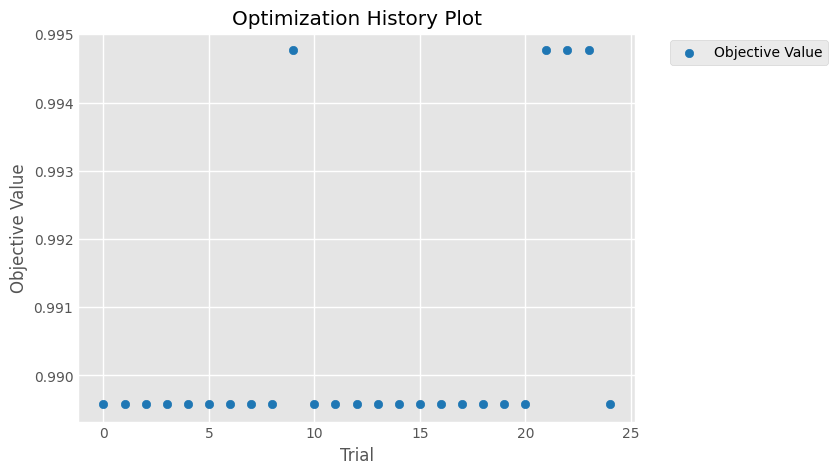

In [70]:
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[metric[METRIC_TO_USE]])

The hyperparameter importances:


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

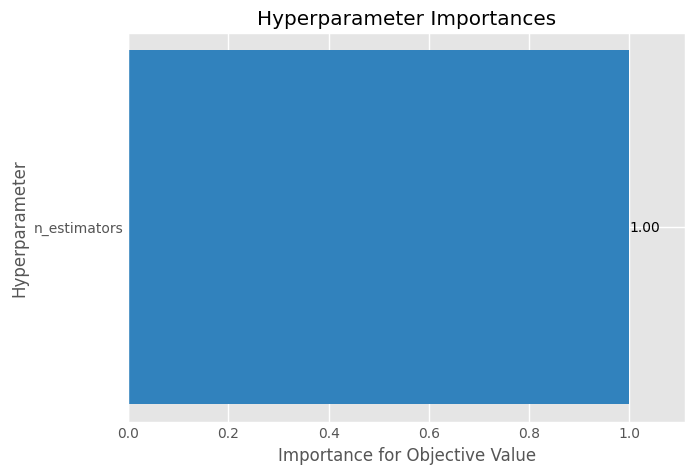

In [71]:
optuna.visualization.matplotlib.plot_param_importances(study, target=lambda t: t.values[metric[METRIC_TO_USE]])

Visualize the loss functions compares to number of estimators during tuning


In [72]:
udf = study_df.drop_duplicates(['params_n_estimators']).sort_values(by='params_n_estimators')
udf_by_score = udf[udf.values_0 == udf.values_0.max()]
udf

,number,values_0,values_1,values_2,datetime_start,datetime_complete,duration,params_n_estimators,system_attrs_nsga2:generation,state
9,9,0.989583,0.994764,0.0,2023-04-12 06:54:22.403850,2023-04-12 06:54:22.745091,0 days 00:00:00.341241,75,0,COMPLETE
2,2,0.979381,0.989583,0.0,2023-04-12 06:54:13.510586,2023-04-12 06:54:13.866344,0 days 00:00:00.355758,100,0,COMPLETE
7,7,0.979381,0.989583,0.0,2023-04-12 06:54:19.511993,2023-04-12 06:54:20.349541,0 days 00:00:00.837548,150,0,COMPLETE
6,6,0.979381,0.989583,0.0,2023-04-12 06:54:18.342841,2023-04-12 06:54:19.504755,0 days 00:00:01.161914,175,0,COMPLETE
1,1,0.979381,0.989583,0.0,2023-04-12 06:54:12.893009,2023-04-12 06:54:13.505213,0 days 00:00:00.612204,200,0,COMPLETE
12,12,0.979381,0.989583,0.0,2023-04-12 06:54:24.252520,2023-04-12 06:54:25.654594,0 days 00:00:01.402074,250,0,COMPLETE
17,17,0.979381,0.989583,0.0,2023-04-12 06:54:30.403319,2023-04-12 06:54:32.941145,0 days 00:00:02.537826,300,0,COMPLETE
0,0,0.979381,0.989583,0.0,2023-04-12 06:54:11.455421,2023-04-12 06:54:12.891296,0 days 00:00:01.435875,400,0,COMPLETE


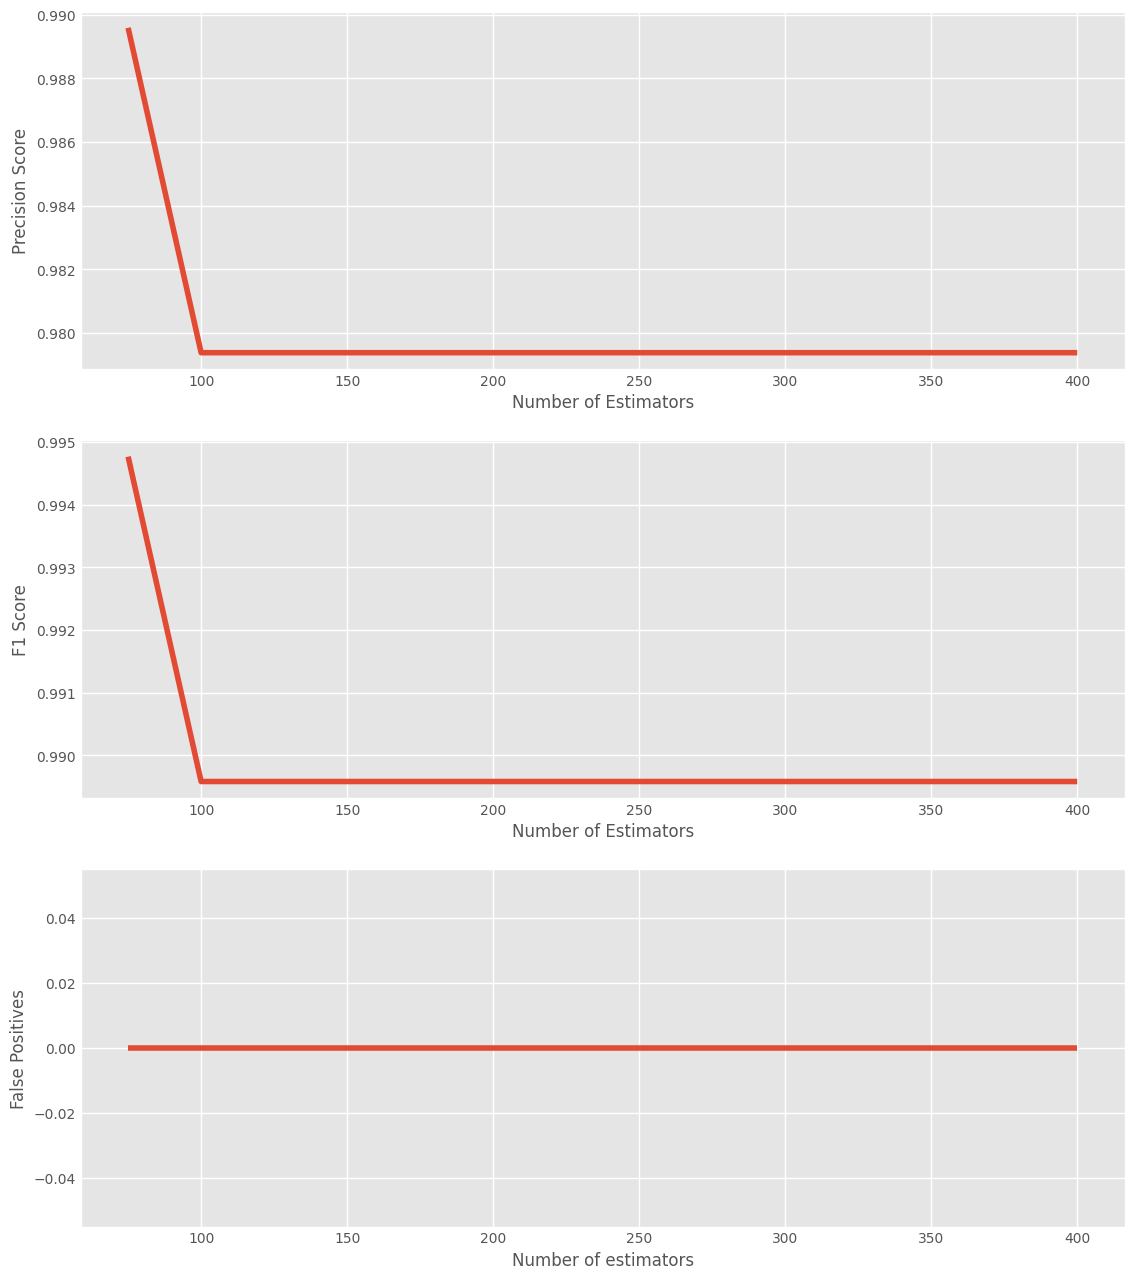

In [73]:
if TREES_ONLY:
    udf = study_df.drop_duplicates(['params_n_estimators']).sort_values(by='params_n_estimators')
    udf_by_score = udf[udf.values_0 == udf.values_0.max()]
    fig, ax = plt.subplots(3, figsize=(12,15))
    ax[0].plot(udf['params_n_estimators'], udf['values_0'], label='Precision per n estimators')
    ax[0].set_xlabel('Number of Estimators')
    ax[0].set_ylabel('Precision Score')
    ax[1].plot(udf['params_n_estimators'], udf['values_1'], label='F1 score per n estimators')
    ax[1].set_xlabel('Number of Estimators')
    ax[1].set_ylabel('F1 Score')
    ax[2].plot(udf['params_n_estimators'], udf['values_2'], label='False positives per n estimators')
    ax[2].set_xlabel('Number of estimators')
    ax[2].set_ylabel('False Positives')

Training the model with the best hyperparamers


In [74]:
hyperparameters = best_trial_params
hyperparameters['n_jobs'] = -1
hyperparameters['warm_start'] = True
print('Using these params:')
pprint(hyperparameters)
classifier = skRF(**hyperparameters)

Using these params:
{'n_estimators': 75, 'n_jobs': -1, 'warm_start': True}


Creating a kFold training strategy to use the new hyperparameters:

In [75]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

Start training the model using the k-Fold strategy to use the best mode, this time after hyperparameter tuning.

In [76]:
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    classifier.fit(X_train_valid, y_train_valid)
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test_valid)
    print(classification_report(y_test_valid, test_predictions))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Train [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303
 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321
 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 

Then we can take the average score from all iterations, and the score of the best model:

In [77]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))
print('Best accuracy score: {}'.format(bestModelScore))

Average accuracy score: 0.99375
Best accuracy score: 1.0


## 6. Model testing and training/testing data validation

Once we have trained our model we can proceed to use the best model and perform testing and validation using our dataset.

### 6.1 Get model metrics

We can calculate accuracy metrics from our model using the test dataset, but we can also output prediction probabilities to understand the drivers behind the model performance.

In [78]:
classifier = bestModel

In [79]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.985

Note how easy it is to perform predictions once we have datasets in dataframe format.

In [80]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [81]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

We can then produce our confusion matrix and get additional information from the score of the model.

In [82]:
print('Train Performance')
print('-------------------------------------------------------')
print(classification_report(y_train, train_predictions))
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Train Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       395
           1       0.99      1.00      0.99       405

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       105
           1       0.98      0.99      0.98        95

    accuracy                           0.98       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.98      0.99       200

Test Recall
-------------------------------------------------------
0.9809523809523809
Confusion Matrix
-------------------------------------------------------
[[103   2]
 [  1  94]]


Note that compared to the previous session, we did remove a false positive. The magnitude of this change might not be well appreciated based on the small dataset we are dealing with here, but can be substantial when dealing with millions of rows and more complex problems.

In [83]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

CPU times: user 2.52 s, sys: 234 ms, total: 2.76 s
Wall time: 5.63 s


By looking at permutation importance we can see which ones are the variables of greater importance.

Text(0.5, 0, 'Permutation Importance')

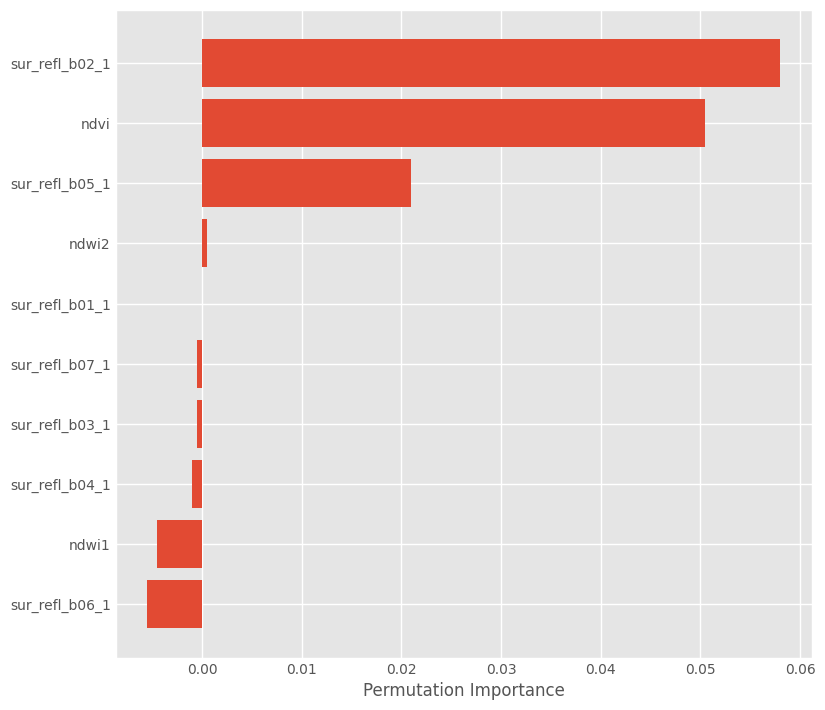

In [84]:
sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [85]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, prediction_probs, y_test_int


## 7. Save the model for future use

We can then save our model for future use so we can apply it or share it elsewhere. The only prerequisite would be for the input dataset to be in the same format as the input training data.

In [86]:
model_save_path = './water_classifier_rf_cpu.sav'
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: ./water_classifier_rf_cpu.sav
RandomForestClassifier(n_estimators=75, n_jobs=-1, warm_start=True)


['./water_classifier_rf_cpu.sav']

## 8. Raster Inference

### 8.1 Data download

Here we can proceed to perform inference using raster objects. The first step is to download some imagery to test with.

In [87]:
powell_dataset = snapshot_download(repo_id=DATASET_URL, allow_patterns="*.tif", repo_type='dataset')

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Then we can select all individual band TIF images and stack them to form the raster needed as input to the model. Note that you can skip this step if you already have your raster that includes all bands.

In [88]:
fileList = sorted([file for file in glob.glob(os.path.join(powell_dataset, 'IL.*.Powell.*.tif')) if 'sur_refl' in file])

Then we can perform some feature engineering on the fly to add some additional column features such as NDVI, NDWI1, and NDWI2.

In [89]:
def readRastersToArray(fileList):
    rasterProjection = None
    newshp = (1300*1300, 10)
    img = np.empty(newshp, dtype=np.int16)
    for i, fileName in enumerate(fileList):
        ds = gdal.Open(fileName)
        img[:, i] = ds.GetRasterBand(1).ReadAsArray().astype(np.int16).ravel()
        if i == 0:
            rasterProjection = ds.GetProjection()
        ds = None
    img[:, len(fileList)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(fileList)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(fileList)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    return img, rasterProjection

We end up with a raster M x N x B, where B is the number of column features that will be included in the model input for inference.

In [90]:
%%time
im, rasterProjection = readRastersToArray(fileList)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 1547  2461   857 ...  2280  -518   510]
 [ 1474  2377   857 ...  2344  -691   337]
 [ 1474  2377   846 ...  2344  -472   623]
 ...
 [ 2358  2979  1028 ...  1163 -1727 -1292]
 [ 2425  3069  1117 ...  1172 -1721 -1216]
 [ 2402  3038  1117 ...  1169 -1770 -1266]]
33.8 MB size
CPU times: user 424 ms, sys: 35.9 ms, total: 460 ms
Wall time: 720 ms


## 8.2 Data preparation
Here we convert our raster array into dataframe format to serve as input to the model.

In [91]:
raster_dataframe = pd.DataFrame(im, columns=v_names, dtype=np.float32)
raster_dataframe

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
0,1547.0,2461.0,857.0,1256.0,2684.0,2730.0,2222.0,2280.0,-518.0,510.0
1,1474.0,2377.0,857.0,1256.0,2684.0,2730.0,2222.0,2344.0,-691.0,337.0
2,1474.0,2377.0,846.0,1230.0,2630.0,2613.0,2098.0,2344.0,-472.0,623.0
3,1494.0,2461.0,846.0,1230.0,2630.0,2613.0,2098.0,2445.0,-299.0,796.0
4,1494.0,2461.0,846.0,1230.0,2630.0,2613.0,2098.0,2445.0,-299.0,796.0
...,...,...,...,...,...,...,...,...,...,...
1689995,2211.0,2826.0,1080.0,1796.0,3650.0,4266.0,3862.0,1220.0,-2030.0,-1549.0
1689996,2209.0,2801.0,1028.0,1791.0,3633.0,4223.0,3863.0,1181.0,-2024.0,-1593.0
1689997,2358.0,2979.0,1028.0,1791.0,3633.0,4223.0,3863.0,1163.0,-1727.0,-1292.0
1689998,2425.0,3069.0,1117.0,1876.0,3747.0,4345.0,3919.0,1172.0,-1721.0,-1216.0


In [92]:
def predictRaster(dataframe, colsToDrop=None):
    """
    Function given a raster in the form of a 
    GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = dataframe.drop(columns=colsToDrop) if colsToDrop else dataframe
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs

Once we have our features in the correct format, we can proceed to perform the inference using the model we previously saved.

In [93]:
%%time
predictedRaster, predictedProbaRaster = predictRaster(raster_dataframe)

Making predictions from raster
CPU times: user 17.9 s, sys: 255 ms, total: 18.1 s
Wall time: 13.9 s


## 8.3 Reshape the unravelled matrix back to the 4800x4800 raster shape

Here we reshape the raster back into its original shape for further visualization.

In [94]:
raster_shape = (1300, 1300)
predictedRasterNdArray = np.asarray(predictedRaster)
predictedRasterMatrix = predictedRasterNdArray.reshape(raster_shape)
predictedRasterMatrix.shape

(1300, 1300)

## 9. Postprocessing
Oftentimes we need to postprocess our output before reaching its final version. There are many postprocessing techniques out there and these will be dependent on your dataset.

### 9.1 Import the QA Mask and the Water Mask for the h09v05 TILE
For this particular problem, we will simply apply MODIS QA maks to our output raster as a postprocessing step.

In [95]:
qa = [file for file in glob.glob(os.path.join(powell_dataset, 'IL.*.Powell.*.tif')) if 'qa' in file][0]
ds = gdal.Open(qa)
qaMask = ds.GetRasterBand(1).ReadAsArray()
qaMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

### 9.2 Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad".

In [96]:
raster_qad = np.where(qaMask == 0, predictedRasterMatrix, 255)

We we can plot a view of our water mask prediction.

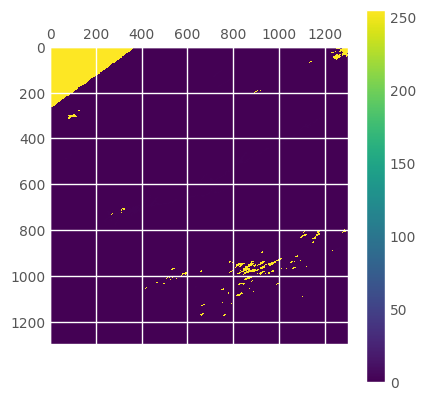

In [97]:
plt.matshow(raster_qad)
plt.colorbar()

### 9.3 Output predicted raster to GeoTiff
We can then output our raster array into a GeoTiff file for further analysis. We can produce Cloud Optimized GeoTIFF (COG) files in this step by simply change the 'GTiff' driver to 'COG'.

In [98]:
geoTransform = (-9961223.407, 231.65635, 0.0, 4285642.633667, 0.0, -231.65635)

predictedPath = 'PowellPredictedWaterMask.tif'

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, 1300, 1300, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geoTransform)
outDs.SetProjection(rasterProjection)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(raster_qad)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

## 10. Visualize your output
We can then proceed to visualize the output of our model in an interactive map. But first, we need to fix the projection in order to properly display the map using the interactive visualization package called folium.

In [99]:
mask_3857 = folium_helper.reproject_to_3857(predictedPath)
mask_d = folium_helper.get_bounds(mask_3857)
mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
folium_helper.cleanup(mask_3857)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
zeros = np.zeros_like(mask_b1)
mask_rgb = np.dstack((mask_b1, zeros, zeros))

Transform: | 491.82, 0.00,-12749861.52|
| 0.00,-491.82, 4656230.30|
| 0.00, 0.00, 1.00|
Width: 1670 Height: 770


From there we can define a basemap and the region of interest for our map to initially start.

In [100]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google')


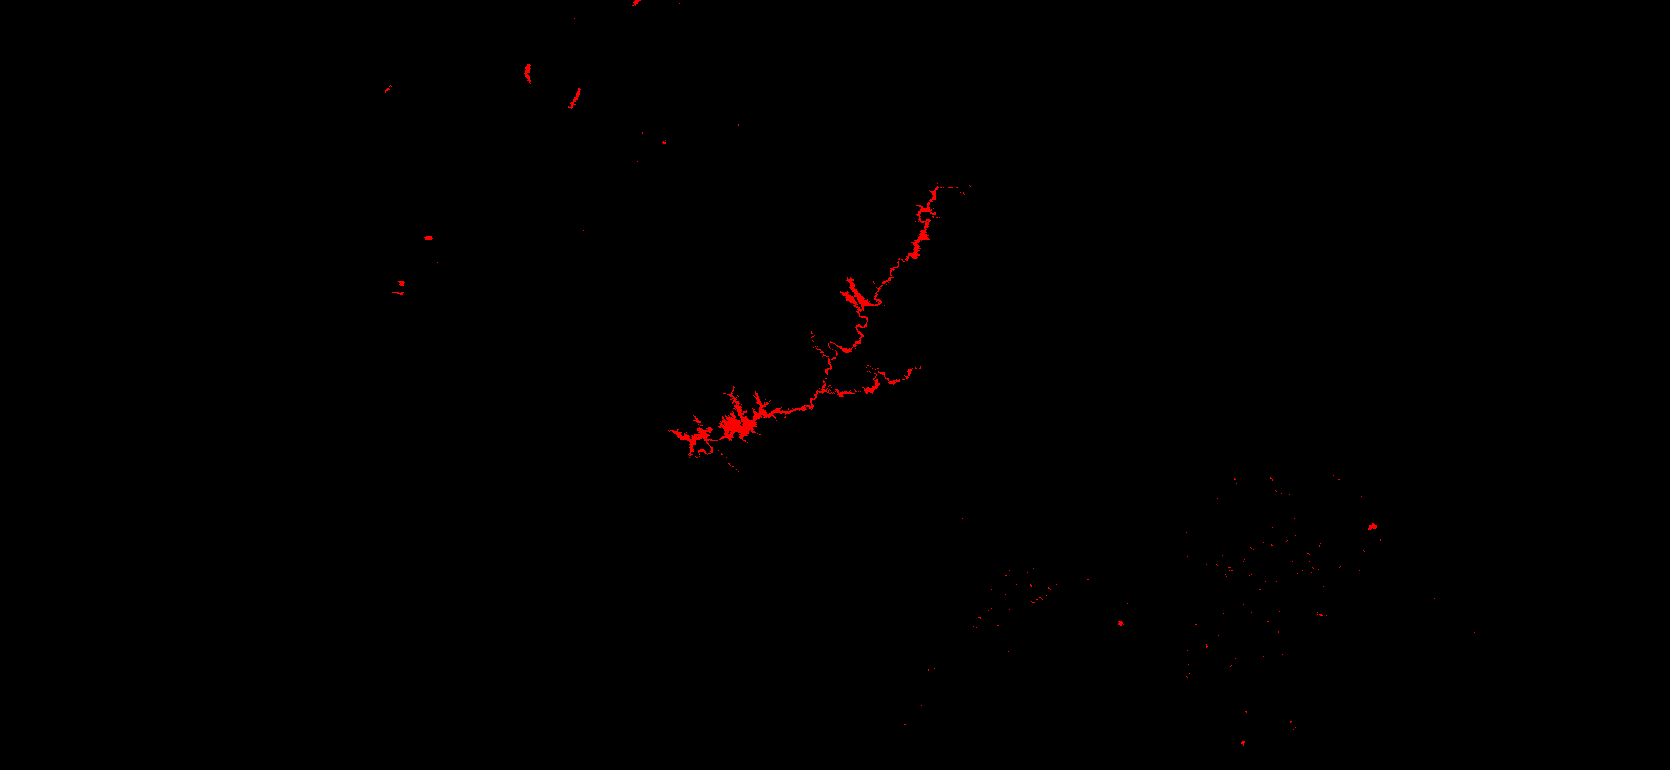

In [101]:
m.add_child(folium_helper.get_overlay(mask_rgb, mask_d, 'Water classification RF predicted mask', opacity=0.6))
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())

## Closing Thoughts

We have:

- Downloaded a MODIS based dataset for training and testing
- Performed gridded automatic parameter optimization techniques for model tuning
- Trained and performed inference of a Random Forest model
- Created interactive visualizations by prediction both tabular and raster datasets
- Provided a base for model explainability which will be discussed in our next session